# Import package

In [1]:
!pip install google-play-scraper
!pip install PySastrawi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 kB 11.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import csv
import re
import unittest
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

from google_play_scraper import app, Sort, reviews
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from typing import List
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC
from wordcloud import WordCloud
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

nltk.download("punkt_tab")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

# Scraping data dari Google Play Store

## Scrapping data from Google Play Store

In [3]:
murder_in_alps = reviews(
    app_id="com.nordcurrent.murderinalps",
    lang="id",
    country="id",
    count=2500,
    sort=Sort.NEWEST)

In [4]:
keys = murder_in_alps[0][0].keys()
data = murder_in_alps[0]

with open("murder_in_alps.csv", "w", newline="") as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(data)

# Data Gathering

## Reviews to Dataframe

In [5]:
df = pd.read_csv("https://raw.githubusercontent.com/mksyfla/analysis-sentiment-using-svm/refs/heads/main/dataset/murder_in_alps_dataset.csv")
df.head(5)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,d2f0315b-2bde-49be-82a7-13b2486a5063,Dina Cahyati,https://play-lh.googleusercontent.com/a/ACg8oc...,"Game nya bagus banget, asik juga karena ngga k...",5,1,11.1.4,2025-05-05 15:46:51,Thank you for the review! We appreciate your k...,2025-05-05 16:22:42,11.1.4
1,9e7959d7-e510-45a1-bb24-a63e3b28d951,alim Alim,https://play-lh.googleusercontent.com/a/ACg8oc...,jangan do dowbload bro soalnya ingin kebergant...,1,0,NaN,2025-04-19 17:20:21,Thank you for your feedback. We apologize for ...,2025-04-19 17:56:10,NaN
2,9aec45e6-8d28-446e-bc8b-f1bc4394b736,Ghaziyah Fitriah,https://play-lh.googleusercontent.com/a/ACg8oc...,Baru liat ada game hidden object yang seniat i...,4,23,11.1.3,2025-04-18 19:26:03,Thank you for your detailed and positive revie...,2025-04-18 20:13:23,11.1.3
3,ae9d0278-1be2-4a39-9aa3-1ce89e8b2033,Hasnah,https://play-lh.googleusercontent.com/a-/ALV-U...,"seru dan menarik, terus agak menantang juga ga...",5,2,11.1.4,2025-04-14 14:13:12,"""Thank you for your intriguing review of Murde...",2025-04-14 14:53:48,11.1.4
4,61d81d88-9a63-4dcf-bcb2-998136803256,Hafiizahh ainur,https://play-lh.googleusercontent.com/a-/ALV-U...,"Bagus tipe gw banget, kemarin main ini ga samp...",5,0,NaN,2025-04-08 07:28:10,Thank you for your detailed review! We're glad...,2025-04-08 08:11:32,NaN


## Normalization Dataset

In [6]:
normalization_df = pd.read_csv("https://raw.githubusercontent.com/mksyfla/analysis-sentiment-using-svm/refs/heads/main/dataset/normalization_lexicon_2.csv")
normalization_dict = normalization_df.set_index("tidak_baku")["kata_baku"].to_dict()

## Delete Unused Column

In [7]:
df = df.drop(columns=["reviewId", "userImage", "reviewCreatedVersion", "replyContent", "repliedAt", "appVersion", "thumbsUpCount"])
df.head(5)

,userName,content,score,at
0,Dina Cahyati,"Game nya bagus banget, asik juga karena ngga k...",5,2025-05-05 15:46:51
1,alim Alim,jangan do dowbload bro soalnya ingin kebergant...,1,2025-04-19 17:20:21
2,Ghaziyah Fitriah,Baru liat ada game hidden object yang seniat i...,4,2025-04-18 19:26:03
3,Hasnah,"seru dan menarik, terus agak menantang juga ga...",5,2025-04-14 14:13:12
4,Hafiizahh ainur,"Bagus tipe gw banget, kemarin main ini ga samp...",5,2025-04-08 07:28:10


# Pre-processing Data

## Cleaning Data

In [8]:
def cleaning_data(text: str) -> str:
    text = re.sub(r"\b[\']\b", "", text)
    text = re.sub(r"[^A-Za-z\s]", " ", text)
    text = re.sub(r"\b[A-Za-z]\b", " ", text)

    return text.strip()

In [9]:
df["cleaning"] = df["content"].apply(cleaning_data)
df[["content", "cleaning"]].head(5)

,content,cleaning
0,"Game nya bagus banget, asik juga karena ngga k...",Game nya bagus banget asik juga karena ngga k...
1,jangan do dowbload bro soalnya ingin kebergant...,jangan do dowbload bro soalnya ingin kebergant...
2,Baru liat ada game hidden object yang seniat i...,Baru liat ada game hidden object yang seniat i...
3,"seru dan menarik, terus agak menantang juga ga...",seru dan menarik terus agak menantang juga ga...
4,"Bagus tipe gw banget, kemarin main ini ga samp...",Bagus tipe gw banget kemarin main ini ga samp...


## Case Folding

In [10]:
def case_folding(data: str) -> str:
    return data.lower()

In [11]:
df["case_folding"] = df["cleaning"].apply(case_folding)
df[["cleaning", "case_folding"]].head(5)

,cleaning,case_folding
0,Game nya bagus banget asik juga karena ngga k...,game nya bagus banget asik juga karena ngga k...
1,jangan do dowbload bro soalnya ingin kebergant...,jangan do dowbload bro soalnya ingin kebergant...
2,Baru liat ada game hidden object yang seniat i...,baru liat ada game hidden object yang seniat i...
3,seru dan menarik terus agak menantang juga ga...,seru dan menarik terus agak menantang juga ga...
4,Bagus tipe gw banget kemarin main ini ga samp...,bagus tipe gw banget kemarin main ini ga samp...


## Tokenization

In [12]:
def tokenization(data: str) -> list[str]:
    return nltk.tokenize.word_tokenize(data)

In [13]:
df["token"] = df["case_folding"].apply(tokenization)
df[["case_folding", "token"]].head(5)

,case_folding,token
0,game nya bagus banget asik juga karena ngga k...,"[game, nya, bagus, banget, asik, juga, karena,..."
1,jangan do dowbload bro soalnya ingin kebergant...,"[jangan, do, dowbload, bro, soalnya, ingin, ke..."
2,baru liat ada game hidden object yang seniat i...,"[baru, liat, ada, game, hidden, object, yang, ..."
3,seru dan menarik terus agak menantang juga ga...,"[seru, dan, menarik, terus, agak, menantang, j..."
4,bagus tipe gw banget kemarin main ini ga samp...,"[bagus, tipe, gw, banget, kemarin, main, ini, ..."


## Normalization

In [14]:
def normalization(texts: list[str]) -> list[str]:
    list_text = list()
    text = ""

    for i in texts:
        if i in normalization_dict:
            list_text.extend(normalization_dict[i].split(" "))
        else:
            list_text.append(i)

    return list_text

In [15]:
df["normalization"] = df["token"].apply(normalization)
df[["token", "normalization"]].head(5)

,token,normalization
0,"[game, nya, bagus, banget, asik, juga, karena,...","[game, nya, bagus, banget, asyik, juga, karena..."
1,"[jangan, do, dowbload, bro, soalnya, ingin, ke...","[jangan, di, unduh, bro, soalnya, ingin, keber..."
2,"[baru, liat, ada, game, hidden, object, yang, ...","[baru, lihat, ada, game, tersembunyi, objek, y..."
3,"[seru, dan, menarik, terus, agak, menantang, j...","[seru, dan, menarik, terus, agak, menantang, j..."
4,"[bagus, tipe, gw, banget, kemarin, main, ini, ...","[bagus, tipe, saya, banget, kemarin, main, ini..."


## Stopword Removal

In [16]:
def stopword_removal(texts: list[str], factory: StopWordRemoverFactory) -> list[str]:
    list_text = list()
    exception_words = ["tidak", "bukan", "jangan", "belum"]

    for text in texts:
        if text in exception_words:
            list_text.append(text)
            continue

        stopword = factory.create_stop_word_remover()
        stopword = stopword.remove(text)

        if len(stopword) != 0:
            list_text.append(stopword)

    return list_text

In [17]:
stopword_factory = StopWordRemoverFactory()
df["stopword"] = df["normalization"].apply(stopword_removal, factory=stopword_factory)
df[["normalization", "stopword"]].head(5)

,normalization,stopword
0,"[game, nya, bagus, banget, asyik, juga, karena...","[game, bagus, banget, asyik, tidak, menantang,..."
1,"[jangan, di, unduh, bro, soalnya, ingin, keber...","[jangan, unduh, bro, kebergantungan, sa, energ..."
2,"[baru, lihat, ada, game, tersembunyi, objek, y...","[game, tersembunyi, objek, seniat, aaa, bagus,..."
3,"[seru, dan, menarik, terus, agak, menantang, j...","[seru, menarik, menantang, gameplay, benda, mi..."
4,"[bagus, tipe, saya, banget, kemarin, main, ini...","[bagus, tipe, banget, kemarin, main, tidak, ta..."


## Negation Handling

In [18]:
def negation_handling(texts: list[str]) -> list[str]:
    list_text = list()
    exception_words = ["tidak", "bukan", "jangan", "belum"]
    negation = False

    for text in texts:
        if text in exception_words:
            negation = True
        elif negation:
            list_text.append("tidak_" + text)
            negation = False
        else:
            list_text.append(text)

    return list_text

In [20]:
df["negasi"] = df["stopword"].apply(negation_handling)
df[["stopword", "negasi"]].head(5)

,stopword,negasi
0,"[game, bagus, banget, asyik, tidak, menantang,...","[game, bagus, banget, asyik, tidak_menantang, ..."
1,"[jangan, unduh, bro, kebergantungan, sa, energ...","[tidak_unduh, bro, kebergantungan, sa, energi,..."
2,"[game, tersembunyi, objek, seniat, aaa, bagus,...","[game, tersembunyi, objek, seniat, aaa, bagus,..."
3,"[seru, menarik, menantang, gameplay, benda, mi...","[seru, menarik, menantang, gameplay, benda, mi..."
4,"[bagus, tipe, banget, kemarin, main, tidak, ta...","[bagus, tipe, banget, kemarin, main, tidak_tam..."


## Stemming

In [21]:
def stemming(texts: list[str], factory: StemmerFactory) -> list[str]:
    list_text = list()

    for text in texts:
        stemmer = factory.create_stemmer()
        stem = stemmer.stem(text)
        list_text.append(stem)

    return list_text

In [23]:
stemmer_factory = StemmerFactory()
df["stemming"] = df["negasi"].apply(stemming, factory=stemmer_factory)
df[["negasi", "stemming"]].head(5)

,negasi,stemming
0,"[game, bagus, banget, asyik, tidak_menantang, ...","[game, bagus, banget, asyik, tidak tantang, mo..."
1,"[tidak_unduh, bro, kebergantungan, sa, energi,...","[tidak unduh, bro, gantung, sa, energi, habis,..."
2,"[game, tersembunyi, objek, seniat, aaa, bagus,...","[game, sembunyi, objek, niat, aaa, bagus, bang..."
3,"[seru, menarik, menantang, gameplay, benda, mi...","[seru, tarik, tantang, gameplay, benda, mister..."
4,"[bagus, tipe, banget, kemarin, main, tidak_tam...","[bagus, tipe, banget, kemarin, main, tidak tam..."


## Export to CSV

In [24]:
df.to_csv("murder_in_alps_dataset_preprocessed.csv", index=False)

# Support Vector Machine Classification

## Preprocessing Dataframe

In [204]:
df = pd.read_csv("https://raw.githubusercontent.com/mksyfla/analysis-sentiment-using-svm/refs/heads/main/dataset/murder_in_alps_dataset_preprocessed.csv")
df.head(5)

,userName,content,score,at,cleaning,case_folding,token,normalization,stopword,stemming
0,Dina Cahyati,"Game nya bagus banget, asik juga karena ngga k...",5,2025-05-05 15:46:51,Game nya bagus banget asik juga karena ngga k...,game nya bagus banget asik juga karena ngga k...,"['game', 'nya', 'bagus', 'banget', 'asik', 'ju...","['game', 'nya', 'bagus', 'banget', 'asyik', 'j...","['game', 'bagus', 'banget', 'asyik', 'menantan...","['game', 'bagus', 'banget', 'asyik', 'tantang'..."
1,alim Alim,jangan do dowbload bro soalnya ingin kebergant...,1,2025-04-19 17:20:21,jangan do dowbload bro soalnya ingin kebergant...,jangan do dowbload bro soalnya ingin kebergant...,"['jangan', 'do', 'dowbload', 'bro', 'soalnya',...","['jangan', 'di', 'unduh', 'bro', 'soalnya', 'i...","['unduh', 'bro', 'kebergantungan', 'sa', 'ener...","['unduh', 'bro', 'gantung', 'sa', 'energi', 'h..."
2,Ghaziyah Fitriah,Baru liat ada game hidden object yang seniat i...,4,2025-04-18 19:26:03,Baru liat ada game hidden object yang seniat i...,baru liat ada game hidden object yang seniat i...,"['baru', 'liat', 'ada', 'game', 'hidden', 'obj...","['baru', 'lihat', 'ada', 'game', 'tersembunyi'...","['game', 'tersembunyi', 'objek', 'seniat', 'aa...","['game', 'sembunyi', 'objek', 'niat', 'aaa', '..."
3,Hasnah,"seru dan menarik, terus agak menantang juga ga...",5,2025-04-14 14:13:12,seru dan menarik terus agak menantang juga ga...,seru dan menarik terus agak menantang juga ga...,"['seru', 'dan', 'menarik', 'terus', 'agak', 'm...","['seru', 'dan', 'menarik', 'terus', 'agak', 'm...","['seru', 'menarik', 'menantang', 'gameplay', '...","['seru', 'tarik', 'tantang', 'gameplay', 'bend..."
4,Hafiizahh ainur,"Bagus tipe gw banget, kemarin main ini ga samp...",5,2025-04-08 07:28:10,Bagus tipe gw banget kemarin main ini ga samp...,bagus tipe gw banget kemarin main ini ga samp...,"['bagus', 'tipe', 'gw', 'banget', 'kemarin', '...","['bagus', 'tipe', 'saya', 'banget', 'kemarin',...","['bagus', 'tipe', 'banget', 'kemarin', 'main',...","['bagus', 'tipe', 'banget', 'kemarin', 'main',..."


## Data Labeling

In [25]:
def labeling_data(score: int) -> str:
    return "positif" if score > 3 else ("netral" if score == 3 else "negatif")

In [26]:
df["sentimen"] = df["score"].apply(labeling_data)
df[["userName", "content", "score", "sentimen"]].head(5)

,userName,content,score,sentimen
0,Dina Cahyati,"Game nya bagus banget, asik juga karena ngga k...",5,positif
1,alim Alim,jangan do dowbload bro soalnya ingin kebergant...,1,negatif
2,Ghaziyah Fitriah,Baru liat ada game hidden object yang seniat i...,4,positif
3,Hasnah,"seru dan menarik, terus agak menantang juga ga...",5,positif
4,Hafiizahh ainur,"Bagus tipe gw banget, kemarin main ini ga samp...",5,positif


In [27]:
df["stemming"] = df["stemming"].apply(lambda x: x if len(x) > 0 else None)
df = df.dropna(subset=["stemming"])
df = df[df["sentimen"] != "netral"]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2140 entries, 0 to 2499
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   userName       2140 non-null   object
 1   content        2140 non-null   object
 2   score          2140 non-null   int64 
 3   at             2140 non-null   object
 4   cleaning       2140 non-null   object
 5   case_folding   2140 non-null   object
 6   token          2140 non-null   object
 7   normalization  2140 non-null   object
 8   stopword       2140 non-null   object
 9   negasi         2140 non-null   object
 10  stemming       2140 non-null   object
 11  sentimen       2140 non-null   object
dtypes: int64(1), object(11)
memory usage: 217.3+ KB


## Data Splitting

In [28]:
x = df["stemming"].apply(lambda x: "".join(x))
y = df["sentimen"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)

## Word Weighting

In [29]:
tfidf = TfidfVectorizer(max_features=5000)
x_train_weight = tfidf.fit_transform(x_train)
x_test_weight = tfidf.transform(x_test)

## Classification

In [30]:
svm_model = SVC(kernel="linear", random_state=42)
svm_model.fit(x_train_weight, y_train)

SVC(kernel='linear', random_state=42)

In [31]:
svm_model.score(x_test_weight, y_test)

0.8492990654205608

In [32]:
y_pred = svm_model.predict(x_test_weight)

# Evaluation Classification

In [33]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
f1 = f1_score(y_test, y_pred, average="weighted")

In [34]:
print("accuracy: {:.2%}".format(accuracy))
print("precision: {:.2%}".format(precision))
print("recall: {:.2%}".format(recall))
print("f1: {:.2%}".format(f1))

accuracy: 84.93%
precision: 79.82%
recall: 84.93%
f1: 79.96%


In [35]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     negatif       0.45      0.07      0.12       127
     positif       0.86      0.98      0.92       729

    accuracy                           0.85       856
   macro avg       0.65      0.53      0.52       856
weighted avg       0.80      0.85      0.80       856



# Visulization

In [36]:
sentimen_count = df.groupby("sentimen").size()
sentimen_count

,0
sentimen,
negatif,309
positif,1831


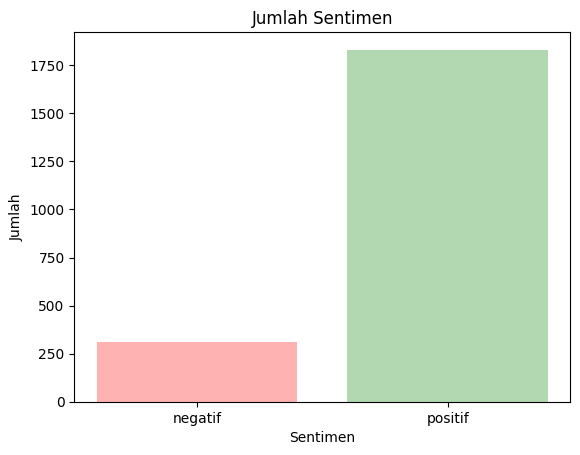

In [37]:
colors = list("rgbkm")
plt.bar(sentimen_count.index, sentimen_count.values, color=colors, alpha=0.3)
plt.xlabel("Sentimen")
plt.ylabel("Jumlah")
plt.title("Jumlah Sentimen")
plt.show()

In [38]:
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud)
    plt.title(title, size=15)
    plt.axis("off")
    plt.show()

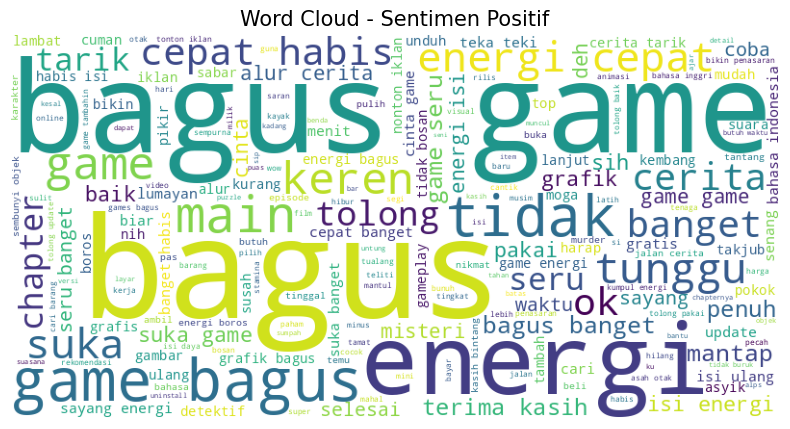

In [39]:
positive_words = [word for word_list in df[df["sentimen"]=="positif"]["stemming"] for word in word_list]
positive_text = " ".join(positive_words)
generate_wordcloud(positive_text, "Word Cloud - Sentimen Positif")

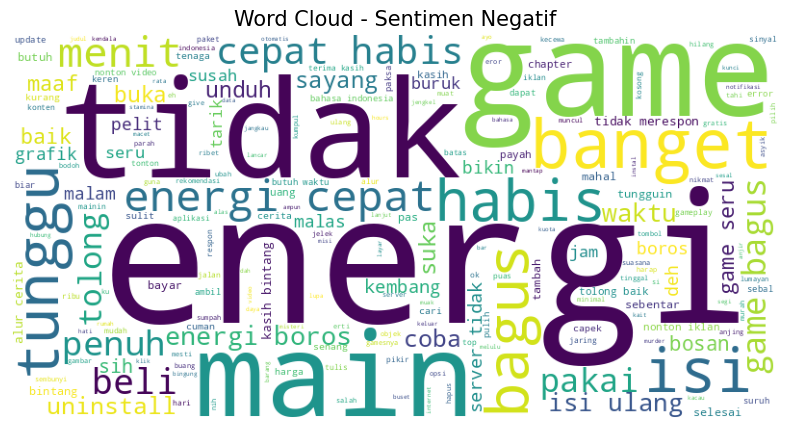

In [40]:
negative_words = [word for word_list in df[df["sentimen"]=="negatif"]["stemming"] for word in word_list]
negative_text = " ".join(negative_words)
generate_wordcloud(negative_text, "Word Cloud - Sentimen Negatif")

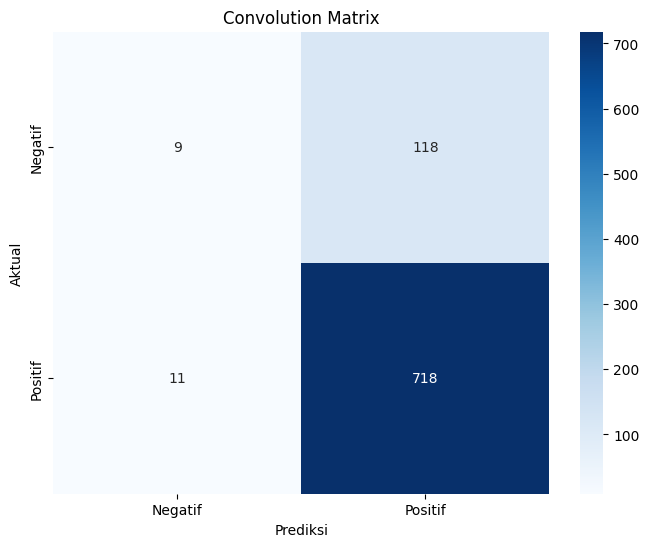

In [41]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negatif", "Positif"], yticklabels=["Negatif", "Positif"])
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.title("Convolution Matrix")
plt.show()